## Mounting Drive

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ./kaggle

## Download Dataset

In [2]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 87% 57.0M/65.2M [00:01<00:00, 64.5MB/s]
100% 65.2M/65.2M [00:01<00:00, 60.3MB/s]


In [17]:
!unzip /content/emotion-detection-fer.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/im37.png  
  inflating: /content/train/sad/im370.png  
  inflating: /content/train/sad/im3700.png  
  inflating: /content/train/sad/im3701.png  
  inflating: /content/train/sad/im3702.png  
  inflating: /content/train/sad/im3703.png  
  inflating: /content/train/sad/im3704.png  
  inflating: /content/train/sad/im3705.png  
  inflating: /content/train/sad/im3706.png  
  inflating: /content/train/sad/im3707.png  
  inflating: /content/train/sad/im3708.png  
  inflating: /content/train/sad/im3709.png  
  inflating: /content/train/sad/im371.png  
  inflating: /content/train/sad/im3710.png  
  inflating: /content/train/sad/im3711.png  
  inflating: /content/train/sad/im3712.png  
  inflating: /content/train/sad/im3713.png  
  inflating: /content/train/sad/im3714.png  
  inflating: /content/train/sad/im3715.png  
  inflating: /content/train/sad/im3716.png  
  inflating: /content/train/sad/im3717.png  
  inflat

In [26]:
cd /content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Emotion-Detection-New

/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Emotion-Detection-New


In [27]:
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print(f"Current working directory: {cwd}")


Current working directory: /content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Emotion-Detection-New


## Importing Libraries

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import imghdr
import cv2

# Importing Deep Learning Libraries
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import compute_class_weight
from keras.models import load_model

In [29]:
folder_path_train = "/content/train"
folder_path_test = "/content/test"

In [30]:
batch_size  = 128
no_of_classes = 7
picture_size = 48

## Data Cleaning

In [31]:
  # Define the list of acceptable image extensions
  image_exts = ['jpeg', 'jpg', 'png']

  # Path to the directory containing image classes and possibly other nested subdirectories
  data_dir = '/content/train'

  # Walk through all directories and files in the dataset
  for root, dirs, files in os.walk(data_dir):
      for file in files:
          # Construct the path to the current file
          file_path = os.path.join(root, file)

          try:
              # Check the file type of the current file
              file_type = imghdr.what(file_path)

              # If the file extension is not in the allowed list, remove it
              if file_type not in image_exts:
                  print(f'Image not in ext list {file_path}')
                  os.remove(file_path)
              else:
                  # Proceed to process the image if needed, for example, reading it with OpenCV
                  img = cv2.imread(file_path)

          except Exception as e:
              # Print out the issue and the path of the problematic file
              print(f'Issue with file {file_path}. Error: {e}')
              # Optionally, remove files that cause exceptions
              os.remove(file_path)

## Data Analysis

In [32]:
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)
        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       neutral  fearful  happy   sad  angry  disgusted  surprised
train     4965     4097   7215  4830   3995        436       3171
      neutral  fearful  happy   sad  angry  disgusted  surprised
test     1233     1024   1774  1247    958        111        831


## Plotting one image from each emotion.

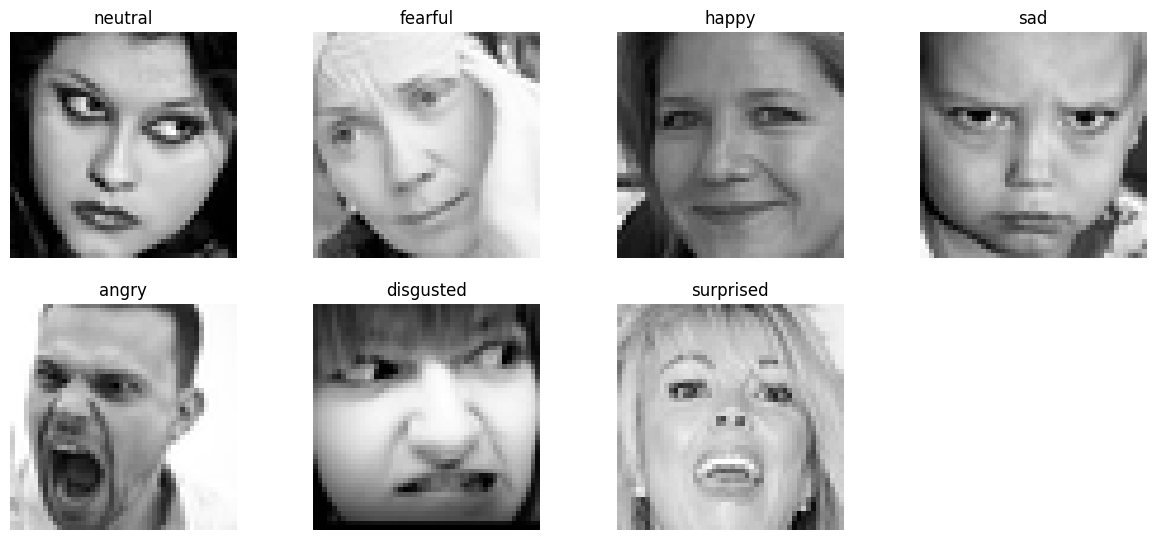

In [33]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## Model-1 (Simple CNN)


In [34]:
datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path_train,
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path_test,
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop

model1 = Sequential()

#1st CNN layer
model1.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

#2nd CNN layer
model1.add(Conv2D(128,(5,5),padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout (0.25))

#3rd CNN layer
model1.add(Conv2D(512,(3,3),padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout (0.25))

#4th CNN layer
model1.add(Conv2D(512,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

#Fully connected 1st layer
model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))


# Fully connected layer 2nd layer
model1.add(Dense(512))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Dense(no_of_classes, activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 50

model1.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model1.fit(train_set,
                      steps_per_epoch=train_set.n//train_set.batch_size,
                      epochs=epochs,
                      validation_data = test_set,
                      validation_steps = test_set.n//test_set.batch_size,
                      callbacks=callbacks_list
                      )

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 1.7907 - accuracy: 0.3071

224/224 [==============================] - 21s 74ms/step - loss: 1.7907 - accuracy: 0.3071 - val_loss: 2.1867 - val_accuracy: 0.3140
Epoch 2/50
223/224 [============================>.] - ETA: 0s - loss: 1.4472 - accuracy: 0.4431

224/224 [==============================] - 16s 73ms/step - loss: 1.4471 - accuracy: 0.4431 - val_loss: 1.4464 - val_accuracy: 0.4495
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 1.2779 - accuracy: 0.5096

224/224 [==============================] - 16s 73ms/step - loss: 1.2779 - accuracy: 0.5096 - val_loss: 1.3238 - val_accuracy: 0.4796
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 1.1870 - accuracy: 0.5462

224/224 [==============================] - 17s 77ms/step - loss: 1.1870 - accuracy: 0.5462 - val_loss: 1.2023 - val_accuracy: 0.5370
Epoch 5/50
224/224 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5707

224/224 [==============================] - 16s 72ms/step - loss: 1.1287 - accuracy: 0.5707 - val_loss: 1.2094 - val_accuracy: 0.5395
Epoch 6/50
224/224 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.5962

224/224 [==============================] - 16s 73ms/step - loss: 1.0686 - accuracy: 0.5962 - val_loss: 1.0994 - val_accuracy: 0.5859
Epoch 7/50
224/224 [==============================] - ETA: 0s - loss: 1.0265 - accuracy: 0.6152

224/224 [==============================] - 16s 72ms/step - loss: 1.0265 - accuracy: 0.6152 - val_loss: 1.1225 - val_accuracy: 0.5774
Epoch 8/50
224/224 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.6287

224/224 [==============================] - 16s 74ms/step - loss: 0.9853 - accuracy: 0.6287 - val_loss: 1.1767 - val_accuracy: 0.5625
Epoch 9/50
224/224 [==============================] - ETA: 0s - loss: 0.9460 - accuracy: 0.6438

224/224 [==============================] - 17s 75ms/step - loss: 0.9460 - accuracy: 0.6438 - val_loss: 1.0831 - val_accuracy: 0.5963
Epoch 10/50
224/224 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.6601

224/224 [==============================] - 16s 72ms/step - loss: 0.9042 - accuracy: 0.6601 - val_loss: 1.0975 - val_accuracy: 0.5837
Epoch 11/50
224/224 [==============================] - ETA: 0s - loss: 0.8603 - accuracy: 0.6786

224/224 [==============================] - 16s 73ms/step - loss: 0.8603 - accuracy: 0.6786 - val_loss: 1.1734 - val_accuracy: 0.5646
Epoch 12/50
224/224 [==============================] - ETA: 0s - loss: 0.8202 - accuracy: 0.6917Restoring model weights from the end of the best epoch: 9.


224/224 [==============================] - 16s 72ms/step - loss: 0.8202 - accuracy: 0.6917 - val_loss: 1.1740 - val_accuracy: 0.5686
Epoch 12: early stopping


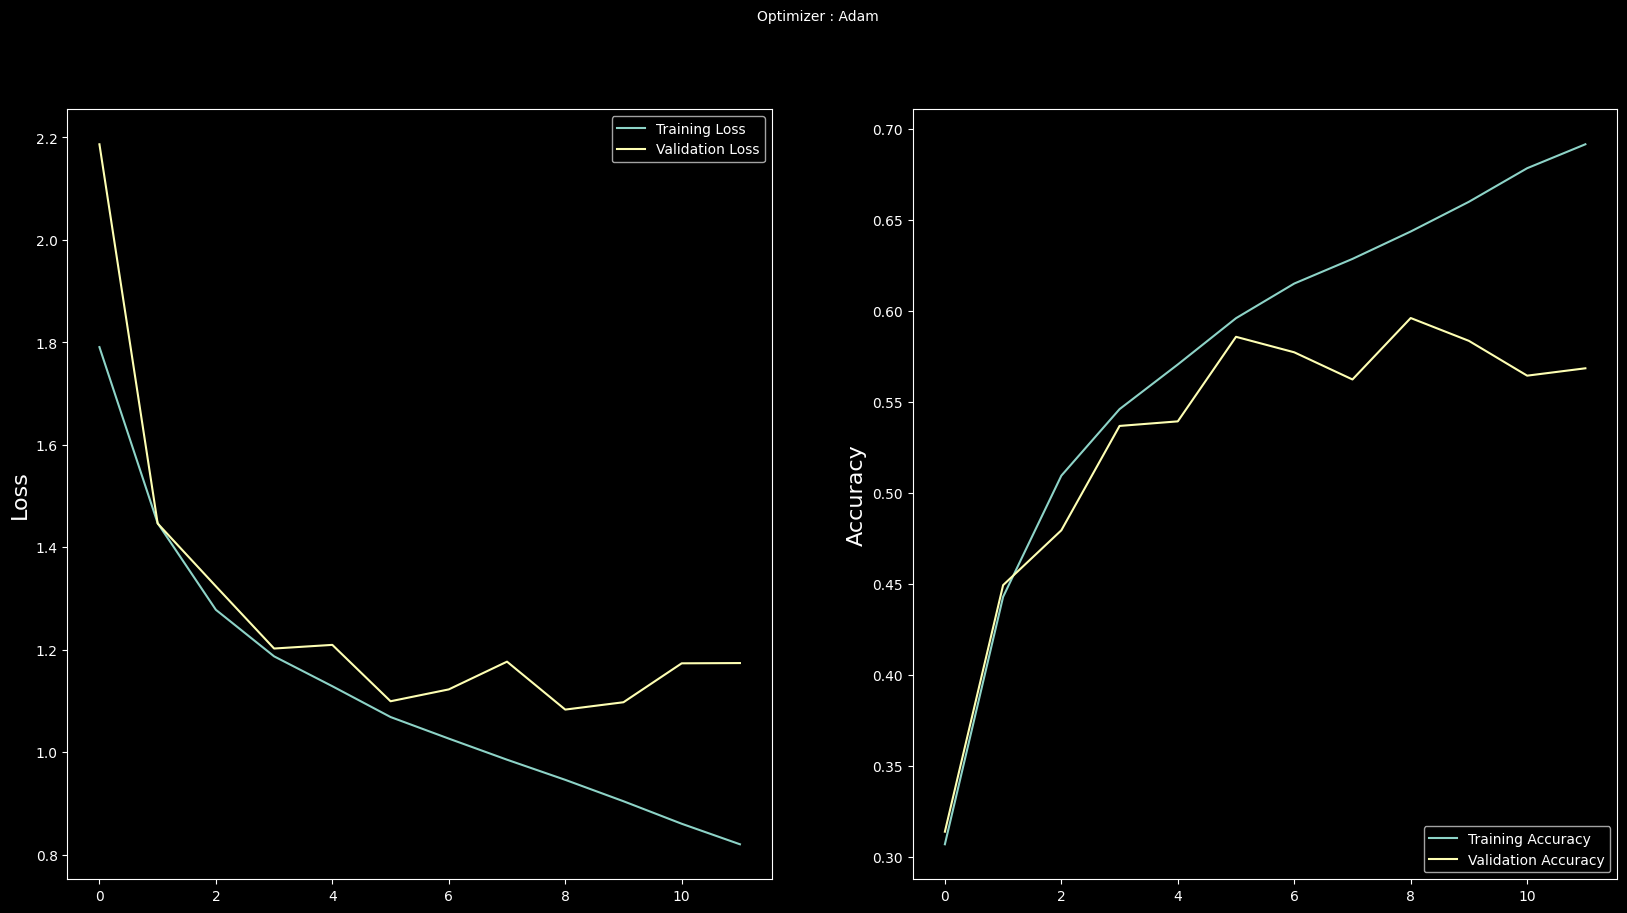

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
train_loss, train_accu = model1.evaluate(train_set)
test_loss, test_accu = model1.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 3s 50ms/step - loss: 1.0846 - accuracy: 0.5961
final train accuracy = 70.39 , validation accuracy = 59.61


57/57 [==============================] - 2s 35ms/step


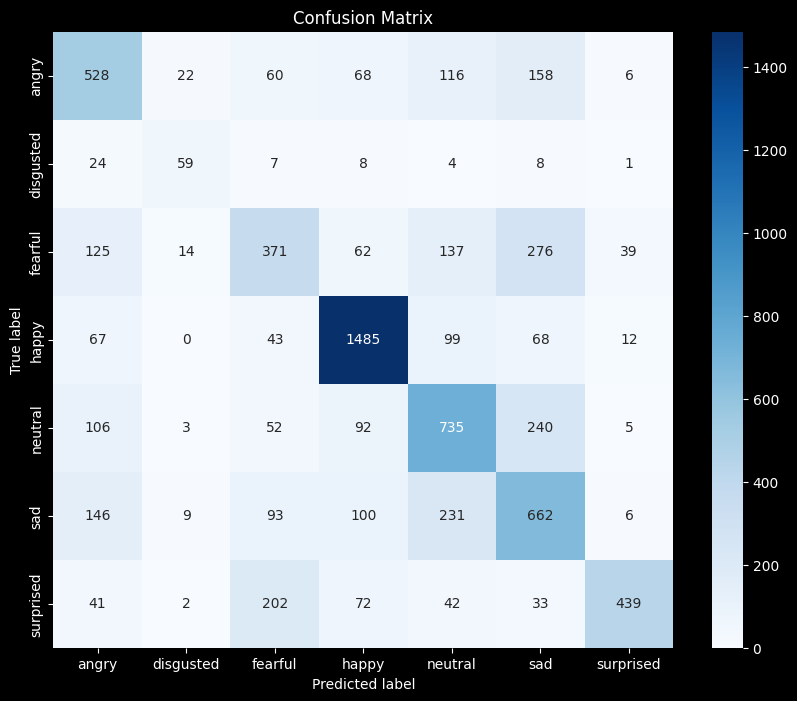

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_set.classes
predicted_classes = np.argmax(model1.predict(test_set), axis=1)
class_labels = list(test_set.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.55      0.53       958
   disgusted       0.54      0.53      0.54       111
     fearful       0.45      0.36      0.40      1024
       happy       0.79      0.84      0.81      1774
     neutral       0.54      0.60      0.57      1233
         sad       0.46      0.53      0.49      1247
   surprised       0.86      0.53      0.66       831

    accuracy                           0.60      7178
   macro avg       0.59      0.56      0.57      7178
weighted avg       0.61      0.60      0.60      7178



In [ ]:
model1.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchModel.h5')

In [36]:
model1 = load_model(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchModel.h5')

### Making Predictions

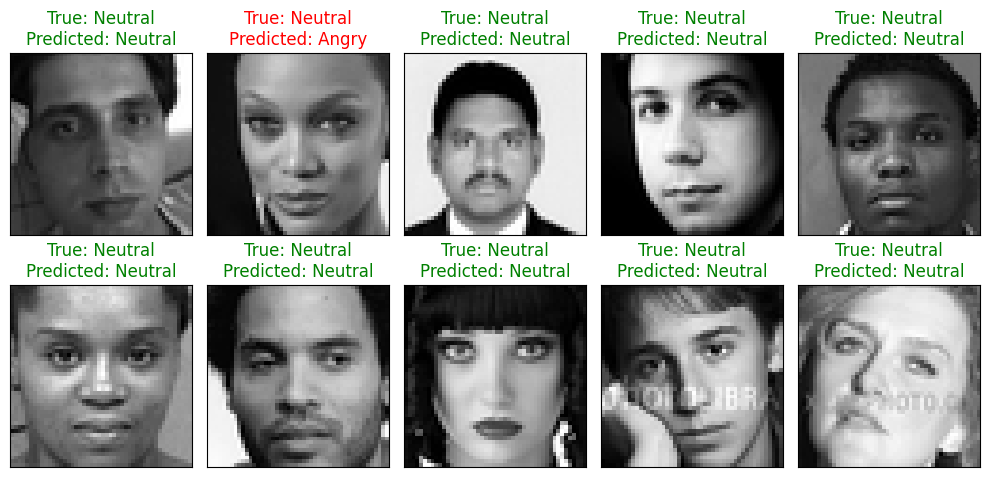

In [37]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_set.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_set) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_set[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_set[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model1.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model-2 (Image Rescaling)


In [41]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    # horizontal_flip=True,  # Randomly flip inputs horizontally

    # rotation_range=40,  # Degree range for random rotations
    # width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    # height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    # shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    # zoom_range=0.2,  # Range for random zoom
    # horizontal_flip=True,  # Randomly flip inputs horizontally
    # fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    # validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
    )

In [42]:
# Automatically retrieve images and their classes for train and validation sets
train_generator = train_data_generator.flow_from_directory(
    folder_path_train,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

Found 28709 images belonging to 7 classes.


In [43]:
test_generator = test_data_generator.flow_from_directory(
    folder_path_test,
    target_size = (picture_size,picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

Found 7178 images belonging to 7 classes.


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model2 = Sequential()

#1st CNN layer
model2.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.25))

#2nd CNN layer
model2.add(Conv2D(128,(5,5),padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout (0.25))

#3rd CNN layer
model2.add(Conv2D(512,(3,3),padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout (0.25))

#4th CNN layer
model2.add(Conv2D(512,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

#Fully connected 1st layer
model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))


# Fully connected layer 2nd layer
model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(no_of_classes, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_24 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 50

model2.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = test_generator,
                                validation_steps = test_generator.n//test_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 1.7924 - accuracy: 0.3096
Epoch 1: val_loss improved from -inf to 1.93577, saving model to ./model2.keras
224/224 [==============================] - 23s 80ms/step - loss: 1.7924 - accuracy: 0.3096 - val_loss: 1.9358 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 1.4403 - accuracy: 0.4483
Epoch 2: val_loss did not improve from 1.93577
224/224 [==============================] - 17s 75ms/step - loss: 1.4403 - accuracy: 0.4483 - val_loss: 1.8285 - val_accuracy: 0.3249 - lr: 0.0010
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.5098
Epoch 3: val_loss did not improve from 1.93577
224/224 [==============================] - 17s 74ms/step - loss: 1.2774 - accuracy: 0.5098 - val_loss: 1.2826 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 1.1843 - accuracy: 0.5503
Epoc

In [ ]:
train_loss, train_accu = model2.evaluate(train_generator)
test_loss, test_accu = model2.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 2s 39ms/step - loss: 1.0889 - accuracy: 0.5917
final train accuracy = 69.38 , validation accuracy = 59.17


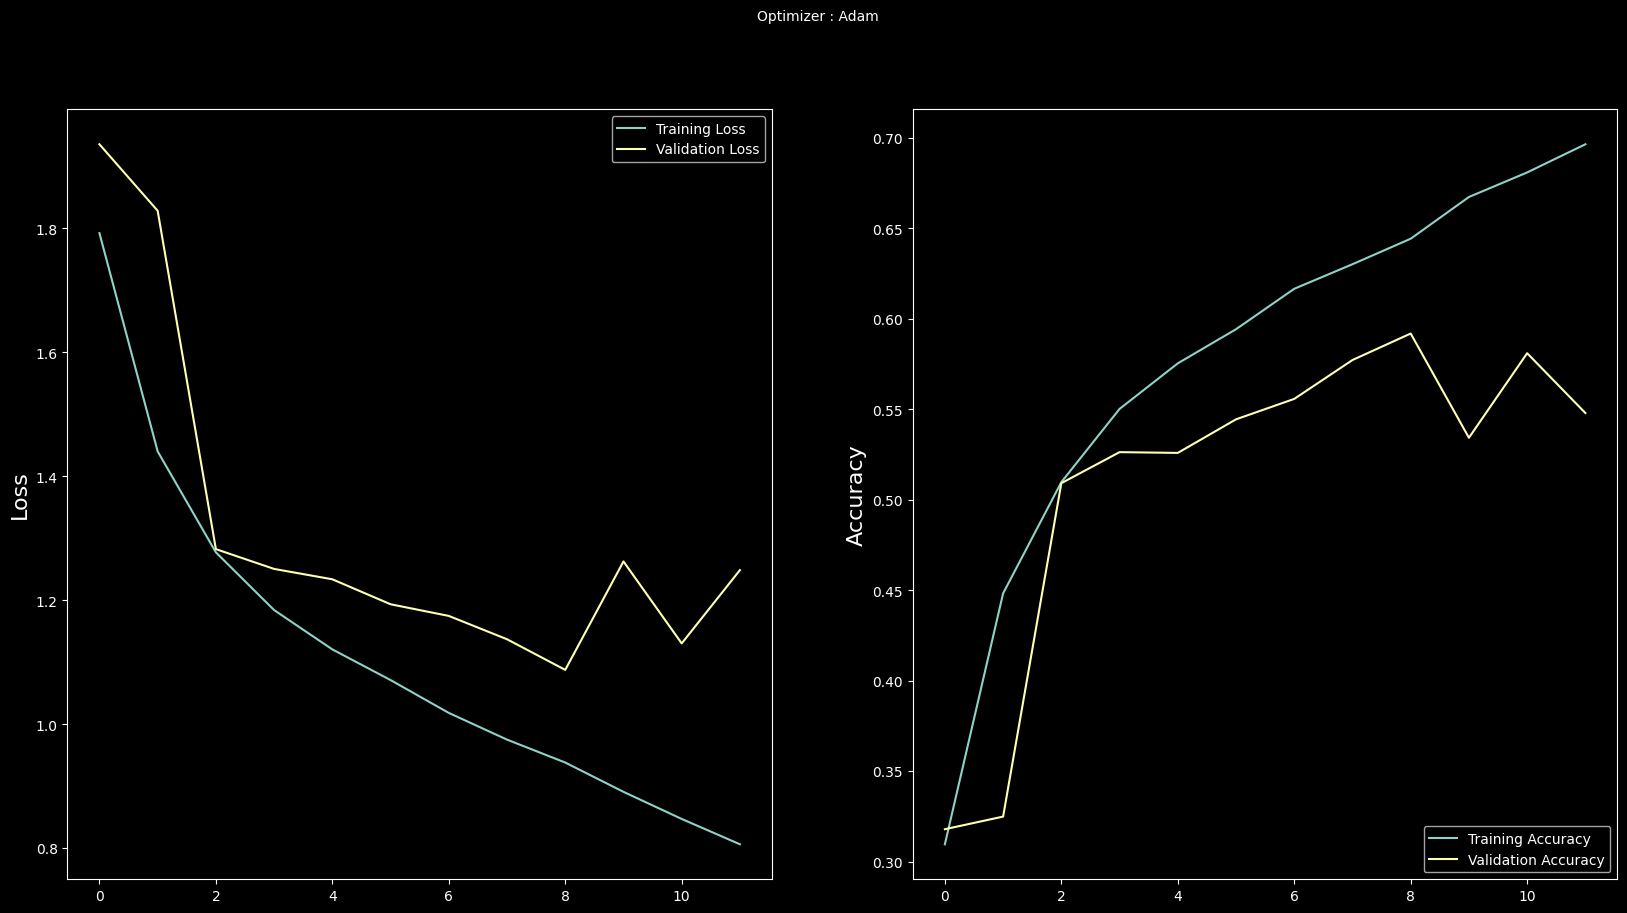

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

57/57 [==============================] - 2s 37ms/step


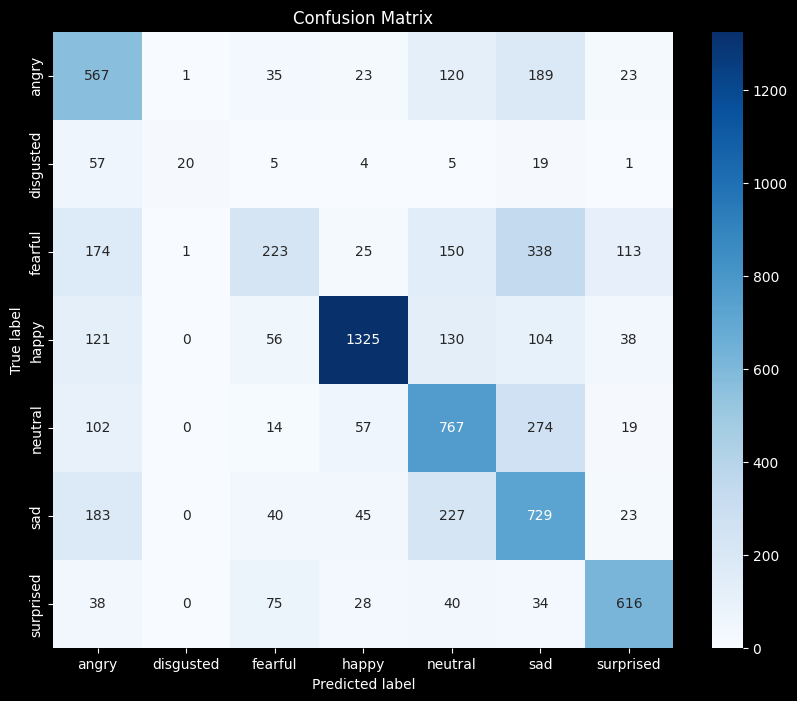

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model2.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.46      0.59      0.52       958
   disgusted       0.91      0.18      0.30       111
     fearful       0.50      0.22      0.30      1024
       happy       0.88      0.75      0.81      1774
     neutral       0.53      0.62      0.57      1233
         sad       0.43      0.58      0.50      1247
   surprised       0.74      0.74      0.74       831

    accuracy                           0.59      7178
   macro avg       0.64      0.53      0.53      7178
weighted avg       0.62      0.59      0.59      7178



In [ ]:
model2.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchRescaledlModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model2 = load_model(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchRescaledlModel.h5')

### Making Predictions

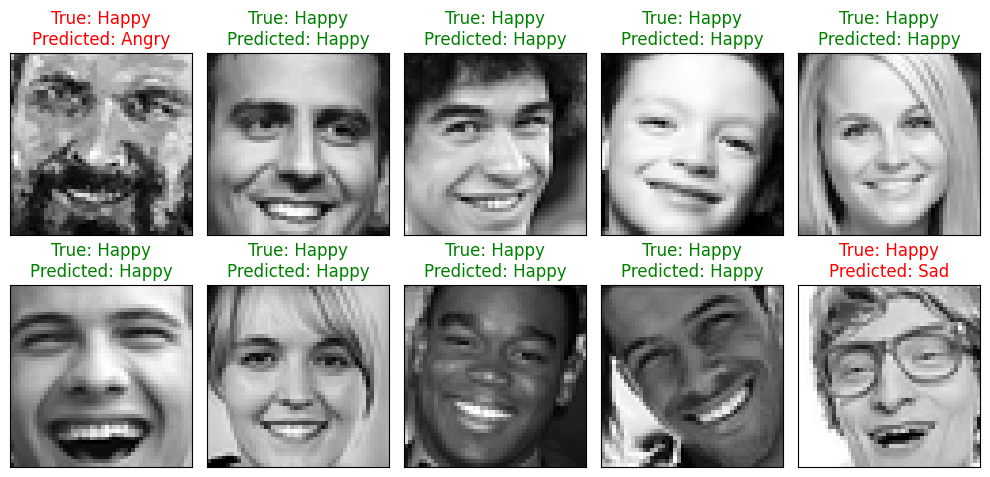

In [48]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model2.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model-3 (Image Augmentation)

In [49]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    horizontal_flip=True,  # Randomly flip inputs horizontally

    # rotation_range=40,  # Degree range for random rotations
    # width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    # height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    # shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    # zoom_range=0.2,  # Range for random zoom
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    # validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
    )

In [50]:
# Automatically retrieve images and their classes for train and validation sets
train_generator = train_data_generator.flow_from_directory(
    folder_path_train,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

Found 28709 images belonging to 7 classes.


In [51]:
test_generator = test_data_generator.flow_from_directory(
    folder_path_test,
    target_size = (picture_size,picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

Found 7178 images belonging to 7 classes.


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model3 = Sequential()

#1st CNN layer
model3.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.25))

#2nd CNN layer
model3.add(Conv2D(128,(5,5),padding = 'same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout (0.25))

#3rd CNN layer
model3.add(Conv2D(512,(3,3),padding = 'same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout (0.25))

#4th CNN layer
model3.add(Conv2D(512,(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())

#Fully connected 1st layer
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))


# Fully connected layer 2nd layer
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(no_of_classes, activation='softmax'))


In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model3.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 50

model3.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = test_generator,
                                validation_steps = test_generator.n//test_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 1.8185 - accuracy: 0.2985
Epoch 1: val_loss improved from -inf to 1.95048, saving model to ./model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


224/224 [==============================] - 25s 87ms/step - loss: 1.8185 - accuracy: 0.2985 - val_loss: 1.9505 - val_accuracy: 0.2102
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 1.4570 - accuracy: 0.4379
Epoch 2: val_loss did not improve from 1.95048
224/224 [==============================] - 26s 115ms/step - loss: 1.4570 - accuracy: 0.4379 - val_loss: 1.6688 - val_accuracy: 0.3876
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.5073
Epoch 3: val_loss did not improve from 1.95048
224/224 [==============================] - 17s 76ms/step - loss: 1.2838 - accuracy: 0.5073 - val_loss: 1.3741 - val_accuracy: 0.4801
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 1.2072 - accuracy: 0.5389
Epoch 4: val_loss did not improve from 1.95048
224/224 [==============================] - 17s 74ms/step - loss: 1.2072 - accuracy: 0.5389 - val_loss: 1.2761 - val_accuracy: 0.5176
Epoch 5/50
224/224 [==================

In [ ]:
train_loss, train_accu = model3.evaluate(train_generator)
test_loss, test_accu = model3.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 2s 42ms/step - loss: 1.0350 - accuracy: 0.6080
final train accuracy = 70.17 , validation accuracy = 60.80


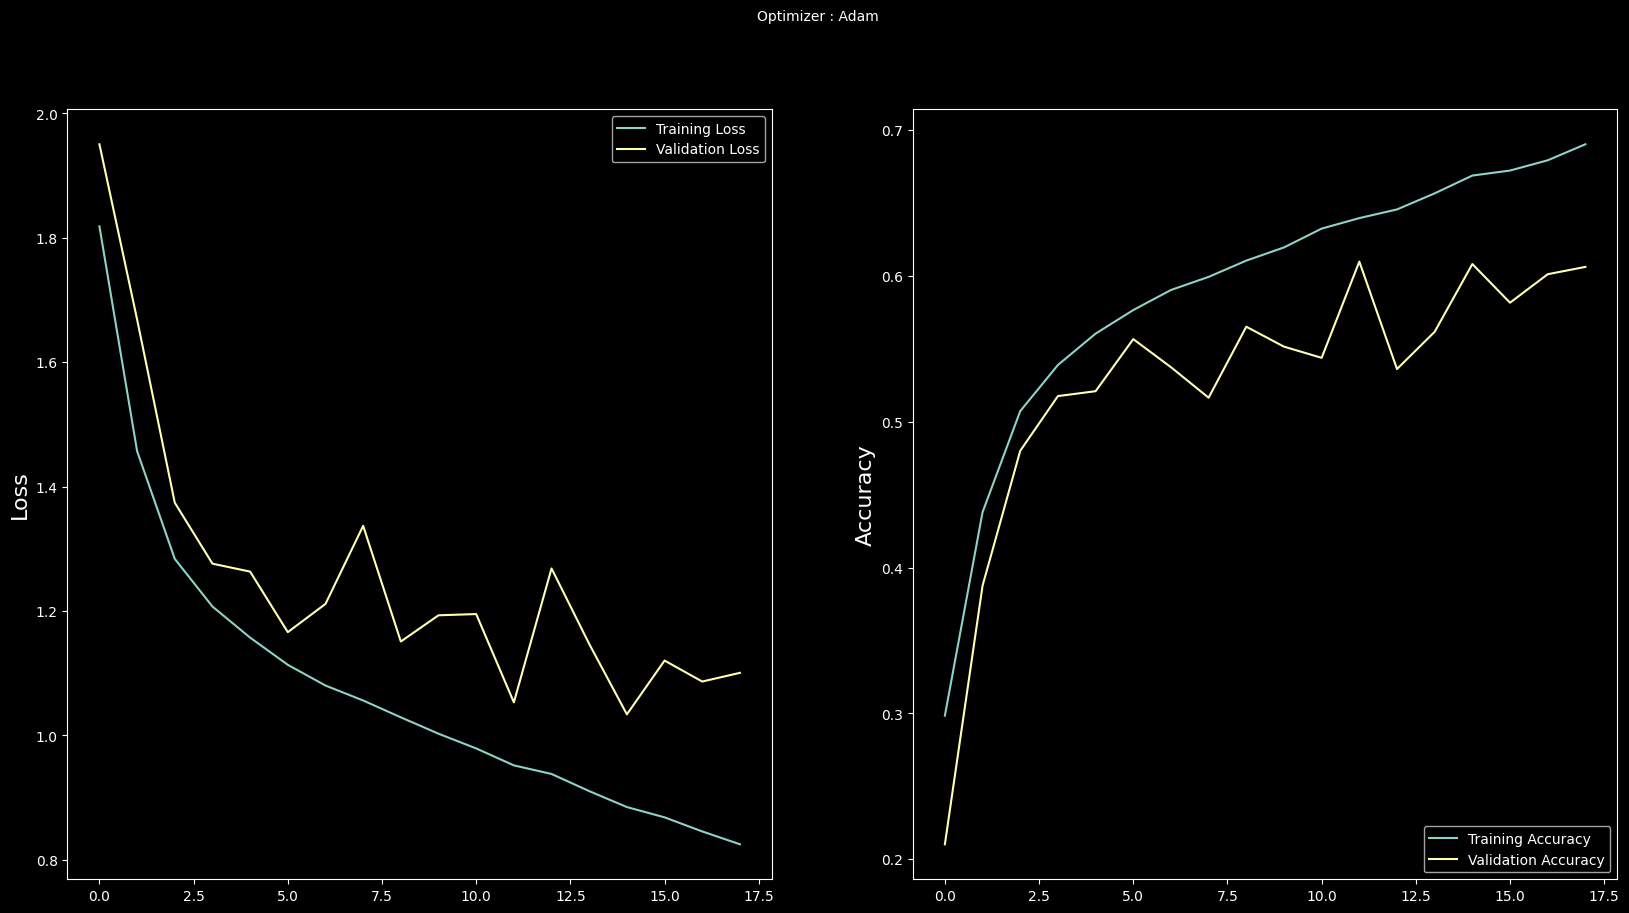

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

57/57 [==============================] - 3s 54ms/step


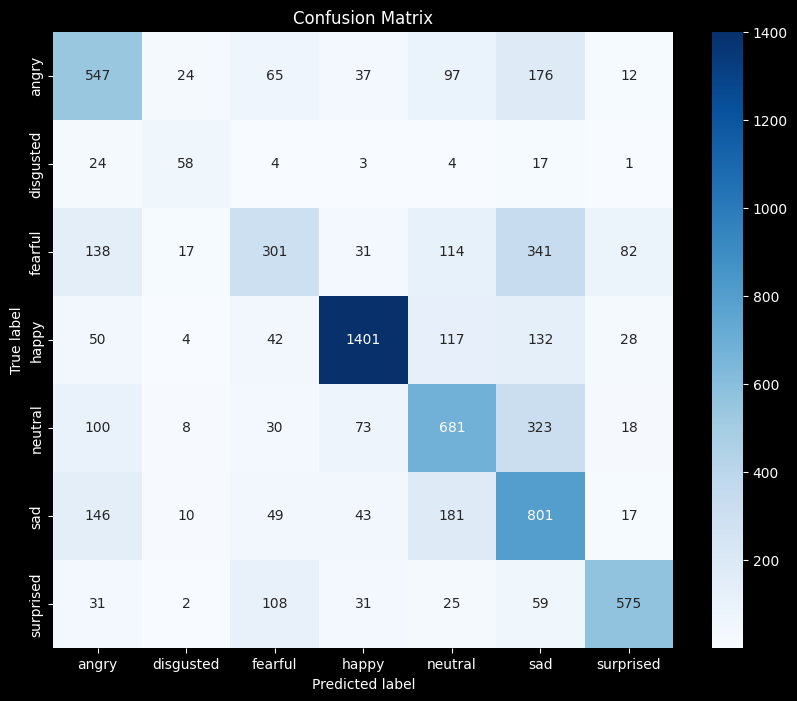

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model3.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.57      0.55       958
   disgusted       0.47      0.52      0.50       111
     fearful       0.50      0.29      0.37      1024
       happy       0.87      0.79      0.83      1774
     neutral       0.56      0.55      0.56      1233
         sad       0.43      0.64      0.52      1247
   surprised       0.78      0.69      0.74       831

    accuracy                           0.61      7178
   macro avg       0.59      0.58      0.58      7178
weighted avg       0.63      0.61      0.61      7178



In [ ]:
model3.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchAugmentedModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
model3 = load_model(r'/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Emotion-Detection-New/CNNFromScratchAugmentedModel.h5')

### Making Predictions

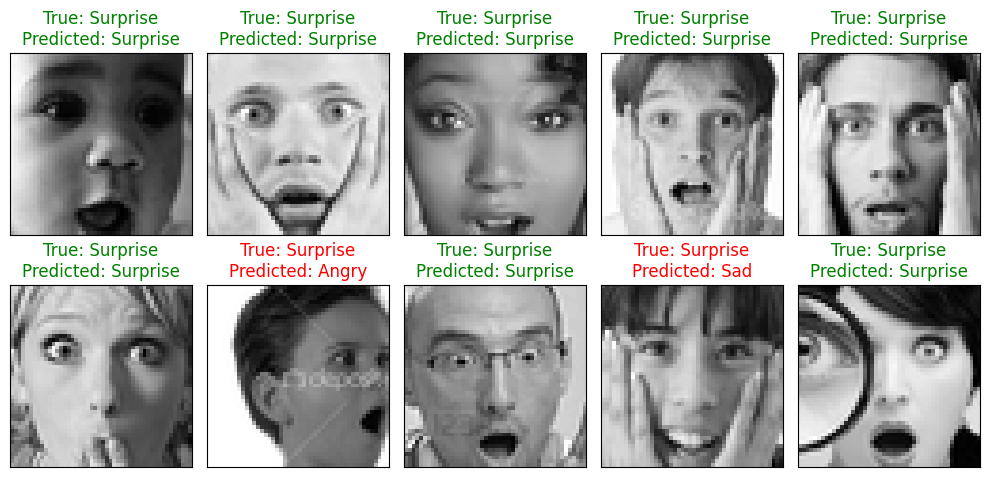

In [55]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model3.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model 4(Pretrained Model VGG-16)

In [71]:
# Set some parameters
img_width, img_height = 48, 48
batch_size = 256
epochs = 10
num_classes = 7

In [72]:
# Rescale the pixel values (0-255) to the [0, 1] interval
datagen_train = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

datagen_val = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [73]:
train_generator = datagen_train.flow_from_directory(folder_path_train,
                                              target_size = (img_width,img_height),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_generator = datagen_val.flow_from_directory(folder_path_test,
                                              target_size = (img_width,img_height),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model4 = Model(inputs=vgg.input, outputs=output)

# Model summary to see all layers
model4.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:


checkpoint = ModelCheckpoint("./model4.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Aggregating all callbacks into a list
callbacks = [checkpoint, early_stopping]  # Adjusted as per your use-case

epochs = 50

model4.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_generator,
                      steps_per_epoch=train_generator.n//train_generator.batch_size,
                      epochs=epochs,
                      validation_data = test_generator,
                      validation_steps = test_generator.n//test_generator.batch_size,
                      callbacks=callbacks
                      )

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 2.6487 - accuracy: 0.2453

112/112 [==============================] - 31s 203ms/step - loss: 2.6487 - accuracy: 0.2453 - val_loss: 1.8180 - val_accuracy: 0.2475
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.8177 - accuracy: 0.2506

112/112 [==============================] - 21s 186ms/step - loss: 1.8177 - accuracy: 0.2506 - val_loss: 1.8138 - val_accuracy: 0.2475
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 1.8171 - accuracy: 0.2503

112/112 [==============================] - 16s 144ms/step - loss: 1.8171 - accuracy: 0.2503 - val_loss: 1.8132 - val_accuracy: 0.2475
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 1.8162 - accuracy: 0.2508

112/112 [==============================] - 16s 143ms/step - loss: 1.8162 - accuracy: 0.2508 - val_loss: 1.8128 - val_accuracy: 0.2475
Epoch 5/50
112/112 [==============================] - ETA: 0s - loss: 1.8149 - accuracy: 0.2510

112/112 [==============================] - 16s 145ms/step - loss: 1.8149 - accuracy: 0.2510 - val_loss: 1.8133 - val_accuracy: 0.2475
Epoch 6/50
112/112 [==============================] - ETA: 0s - loss: 1.8150 - accuracy: 0.2510

112/112 [==============================] - 18s 164ms/step - loss: 1.8150 - accuracy: 0.2510 - val_loss: 1.8133 - val_accuracy: 0.2475
Epoch 7/50
112/112 [==============================] - ETA: 0s - loss: 1.8147 - accuracy: 0.2511

Restoring model weights from the end of the best epoch: 4.
112/112 [==============================] - 20s 181ms/step - loss: 1.8147 - accuracy: 0.2511 - val_loss: 1.8132 - val_accuracy: 0.2475
Epoch 7: early stopping


In [ ]:
train_loss, train_accu = model4.evaluate(train_generator)
test_loss, test_accu = model4.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

29/29 [==============================] - 4s 134ms/step - loss: 1.8134 - accuracy: 0.2471
final train accuracy = 25.13 , validation accuracy = 24.71


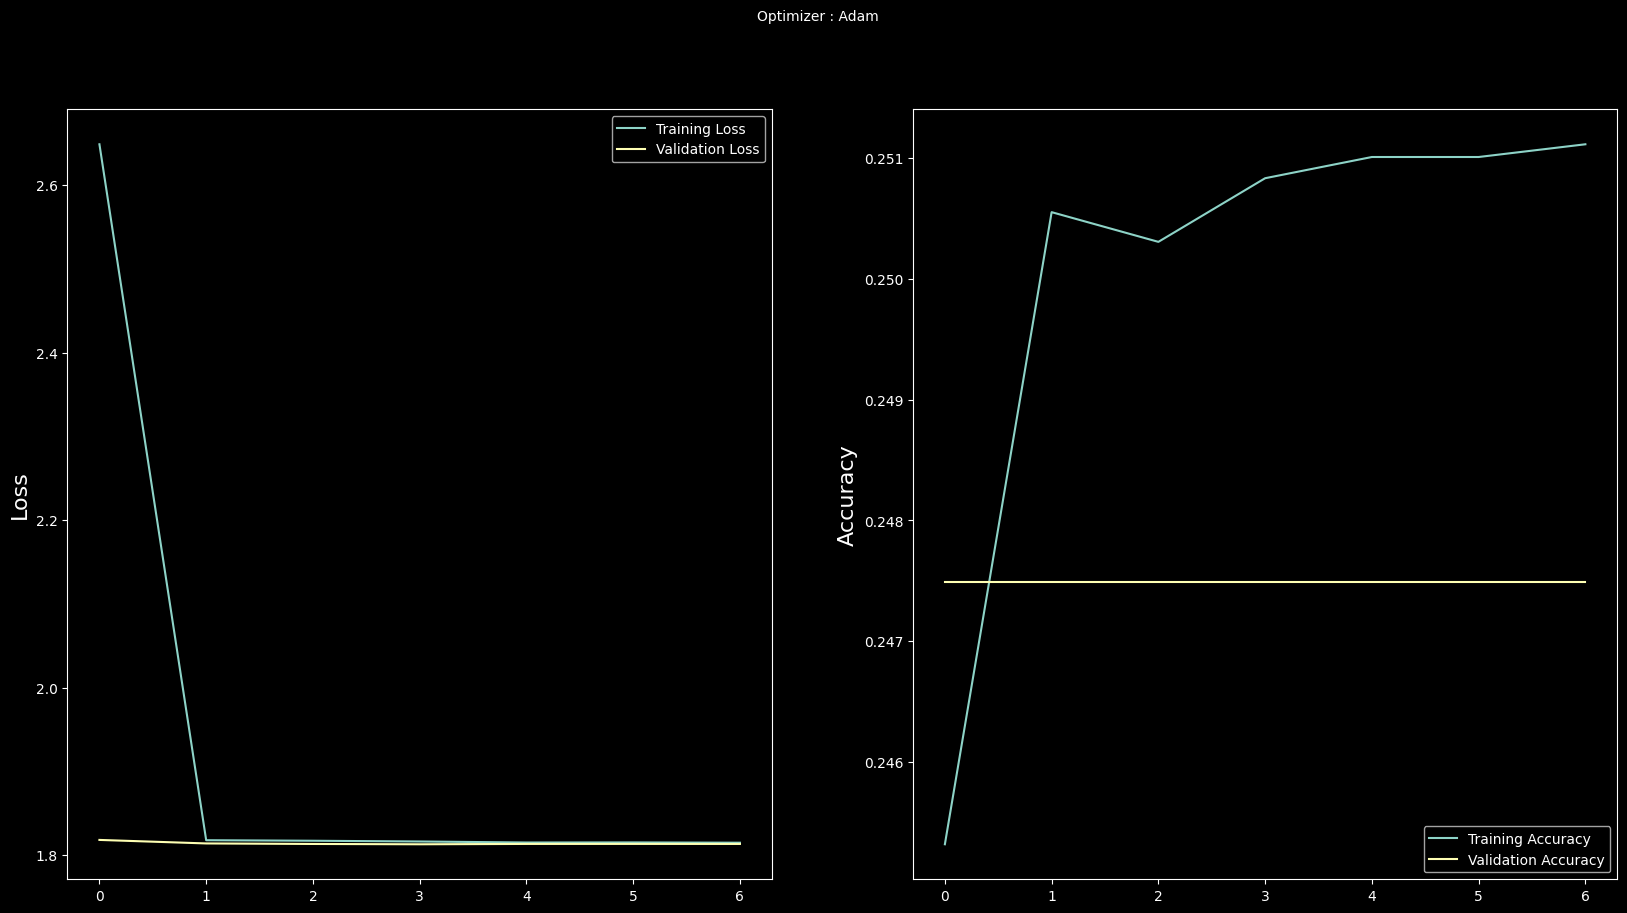

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

29/29 [==============================] - 3s 100ms/step


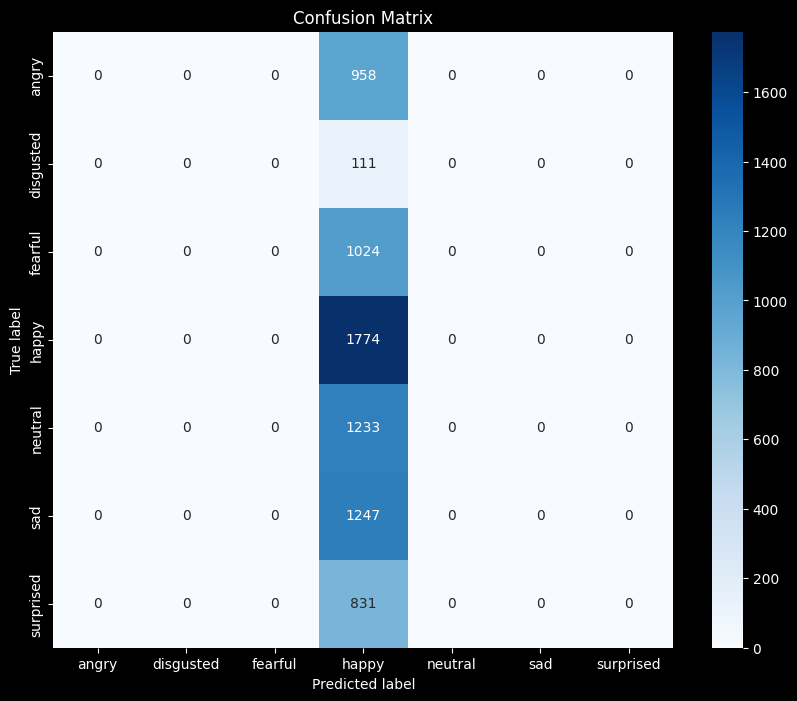

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model4.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
   surprised       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model4.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/TretrainedVGG.h5')

In [74]:
model4 = load_model(r'/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Emotion-Detection-New/TretrainedVGG.h5')

### Making Predictions

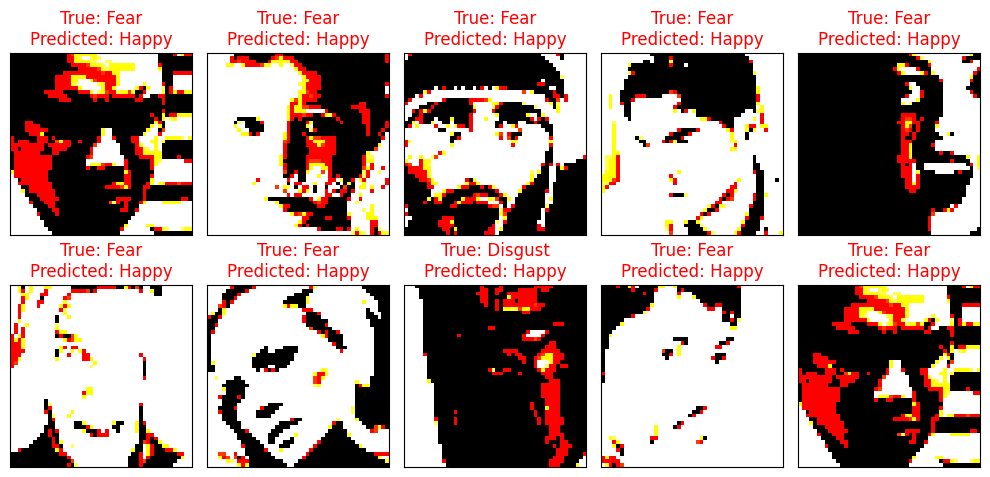

In [75]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model4.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model 5 (VGG Augementation)

In [80]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 256
epochs = 50
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                shuffle = False)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
classes = 7
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model5 = Model(inputs=vgg.input, outputs=output)

# Compile the model
model5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model5.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint("./model5.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case


In [ ]:
history5 = model5.fit(train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_generator.n//test_generator.batch_size,
    callbacks=callbacks
    )

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 1.8207 - accuracy: 0.2502

112/112 [==============================] - 43s 363ms/step - loss: 1.8207 - accuracy: 0.2502 - val_loss: 1.7002 - val_accuracy: 0.3132
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.7331 - accuracy: 0.2976

112/112 [==============================] - 38s 343ms/step - loss: 1.7331 - accuracy: 0.2976 - val_loss: 1.6774 - val_accuracy: 0.3265
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.3148

112/112 [==============================] - 45s 404ms/step - loss: 1.6987 - accuracy: 0.3148 - val_loss: 1.6362 - val_accuracy: 0.3390
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 1.6582 - accuracy: 0.3342

112/112 [==============================] - 40s 355ms/step - loss: 1.6582 - accuracy: 0.3342 - val_loss: 1.6376 - val_accuracy: 0.3316
Epoch 5/50
112/112 [==============================] - ETA: 0s - loss: 1.6412 - accuracy: 0.3379

112/112 [==============================] - 38s 335ms/step - loss: 1.6412 - accuracy: 0.3379 - val_loss: 1.5901 - val_accuracy: 0.3629
Epoch 6/50
112/112 [==============================] - ETA: 0s - loss: 1.6201 - accuracy: 0.3471

112/112 [==============================] - 38s 344ms/step - loss: 1.6201 - accuracy: 0.3471 - val_loss: 1.5455 - val_accuracy: 0.3841
Epoch 7/50
112/112 [==============================] - ETA: 0s - loss: 1.5979 - accuracy: 0.3566

112/112 [==============================] - 39s 349ms/step - loss: 1.5979 - accuracy: 0.3566 - val_loss: 1.5342 - val_accuracy: 0.3884
Epoch 8/50
112/112 [==============================] - ETA: 0s - loss: 1.5928 - accuracy: 0.3613

112/112 [==============================] - 40s 355ms/step - loss: 1.5928 - accuracy: 0.3613 - val_loss: 1.5242 - val_accuracy: 0.3924
Epoch 9/50
112/112 [==============================] - ETA: 0s - loss: 1.5813 - accuracy: 0.3651

112/112 [==============================] - 39s 344ms/step - loss: 1.5813 - accuracy: 0.3651 - val_loss: 1.5207 - val_accuracy: 0.3923
Epoch 10/50
112/112 [==============================] - ETA: 0s - loss: 1.5724 - accuracy: 0.3740

112/112 [==============================] - 39s 344ms/step - loss: 1.5724 - accuracy: 0.3740 - val_loss: 1.5211 - val_accuracy: 0.3934
Epoch 11/50
112/112 [==============================] - ETA: 0s - loss: 1.5620 - accuracy: 0.3752

112/112 [==============================] - 39s 347ms/step - loss: 1.5620 - accuracy: 0.3752 - val_loss: 1.5621 - val_accuracy: 0.3786
Epoch 12/50
112/112 [==============================] - ETA: 0s - loss: 1.5646 - accuracy: 0.3763

Restoring model weights from the end of the best epoch: 9.
112/112 [==============================] - 39s 348ms/step - loss: 1.5646 - accuracy: 0.3763 - val_loss: 1.5490 - val_accuracy: 0.3765
Epoch 12: early stopping


In [ ]:
train_loss, train_accu = model5.evaluate(train_generator)
test_loss, test_accu = model5.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

29/29 [==============================] - 3s 88ms/step - loss: 1.5197 - accuracy: 0.3929
final train accuracy = 37.91 , validation accuracy = 39.29


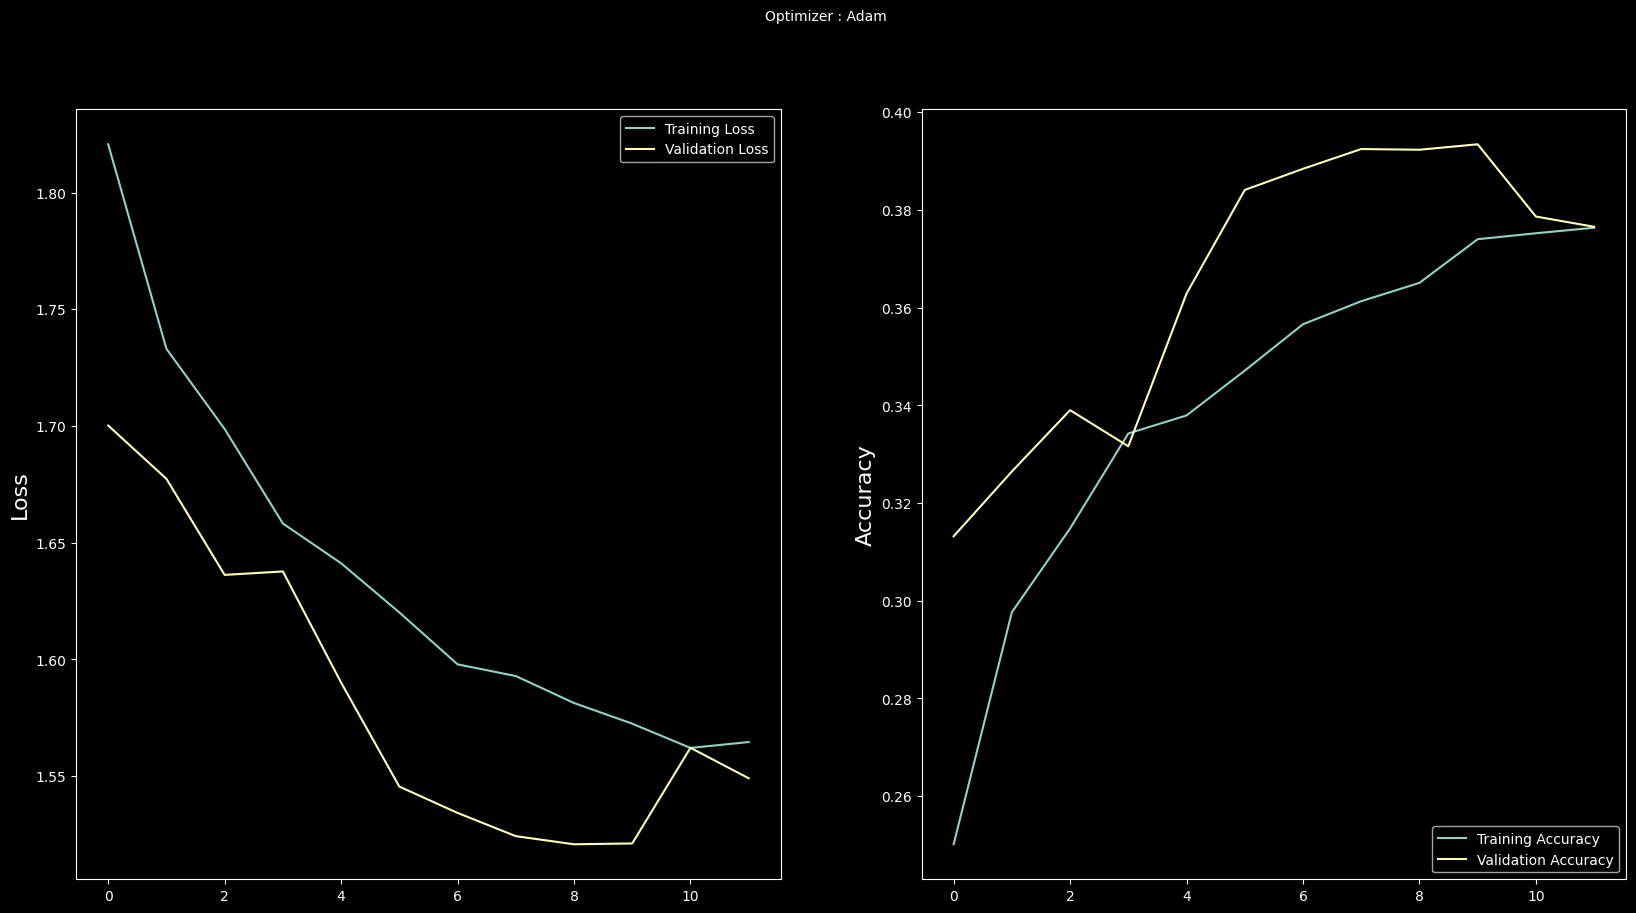

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

29/29 [==============================] - 3s 107ms/step


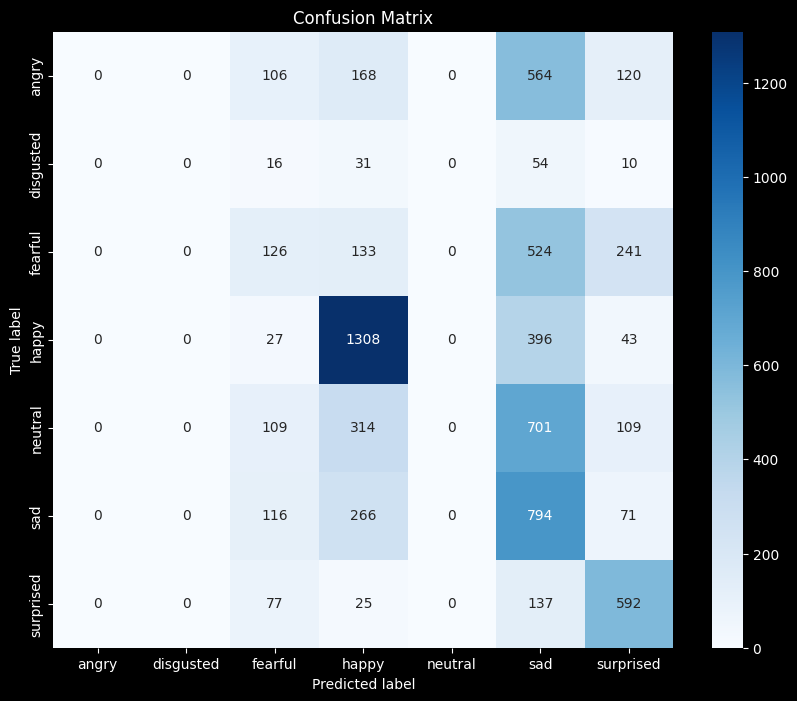

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model5.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.22      0.12      0.16      1024
       happy       0.58      0.74      0.65      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.25      0.64      0.36      1247
   surprised       0.50      0.71      0.59       831

    accuracy                           0.39      7178
   macro avg       0.22      0.32      0.25      7178
weighted avg       0.28      0.39      0.31      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model5.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/TretrainedVGGAugmeted.h5')

##Model 6 (VGG Pretrained and Augementation)

In [82]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 256
epochs = 50
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                rescale = 1 / 255.,
                                # rotation_range=10,
                                # zoom_range=0.2,
                                # width_shift_range=0.1,
                                # height_shift_range=0.1,
                                # horizontal_flip=True,
                                # fill_mode='nearest',
                                # # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                shuffle = False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [83]:
from tensorflow.keras.applications import VGG16
classes = 7
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model6 = Model(inputs=vgg.input, outputs=output)

# Compile the model
model6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model6.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint("./model6.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case


In [ ]:
history6 = model6.fit(train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_generator.n//test_generator.batch_size,
    callbacks=callbacks
    )

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 1.7817 - accuracy: 0.2686

112/112 [==============================] - 23s 180ms/step - loss: 1.7817 - accuracy: 0.2686 - val_loss: 1.6761 - val_accuracy: 0.3231
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.6643 - accuracy: 0.3246

112/112 [==============================] - 17s 150ms/step - loss: 1.6643 - accuracy: 0.3246 - val_loss: 1.6184 - val_accuracy: 0.3482
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.3562

112/112 [==============================] - 17s 151ms/step - loss: 1.6140 - accuracy: 0.3562 - val_loss: 1.5838 - val_accuracy: 0.3733
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 1.5534 - accuracy: 0.3784

112/112 [==============================] - 19s 165ms/step - loss: 1.5534 - accuracy: 0.3784 - val_loss: 1.5375 - val_accuracy: 0.3972
Epoch 5/50
112/112 [==============================] - ETA: 0s - loss: 1.5205 - accuracy: 0.3928

112/112 [==============================] - 23s 203ms/step - loss: 1.5205 - accuracy: 0.3928 - val_loss: 1.4976 - val_accuracy: 0.4021
Epoch 6/50
112/112 [==============================] - ETA: 0s - loss: 1.4804 - accuracy: 0.4070

112/112 [==============================] - 16s 146ms/step - loss: 1.4804 - accuracy: 0.4070 - val_loss: 1.5356 - val_accuracy: 0.3881
Epoch 7/50
112/112 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.4206

112/112 [==============================] - 16s 146ms/step - loss: 1.4463 - accuracy: 0.4206 - val_loss: 1.4669 - val_accuracy: 0.4180
Epoch 8/50
112/112 [==============================] - ETA: 0s - loss: 1.4143 - accuracy: 0.4362

112/112 [==============================] - 16s 145ms/step - loss: 1.4143 - accuracy: 0.4362 - val_loss: 1.4686 - val_accuracy: 0.4116
Epoch 9/50
112/112 [==============================] - ETA: 0s - loss: 1.3810 - accuracy: 0.4506

112/112 [==============================] - 16s 147ms/step - loss: 1.3810 - accuracy: 0.4506 - val_loss: 1.4765 - val_accuracy: 0.4109
Epoch 10/50
112/112 [==============================] - ETA: 0s - loss: 1.3440 - accuracy: 0.4642

Restoring model weights from the end of the best epoch: 7.
112/112 [==============================] - 17s 148ms/step - loss: 1.3440 - accuracy: 0.4642 - val_loss: 1.5219 - val_accuracy: 0.3895
Epoch 10: early stopping


In [ ]:
train_loss, train_accu = model6.evaluate(train_generator)
test_loss, test_accu = model6.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

29/29 [==============================] - 6s 208ms/step - loss: 1.4665 - accuracy: 0.4182
final train accuracy = 45.00 , validation accuracy = 41.82


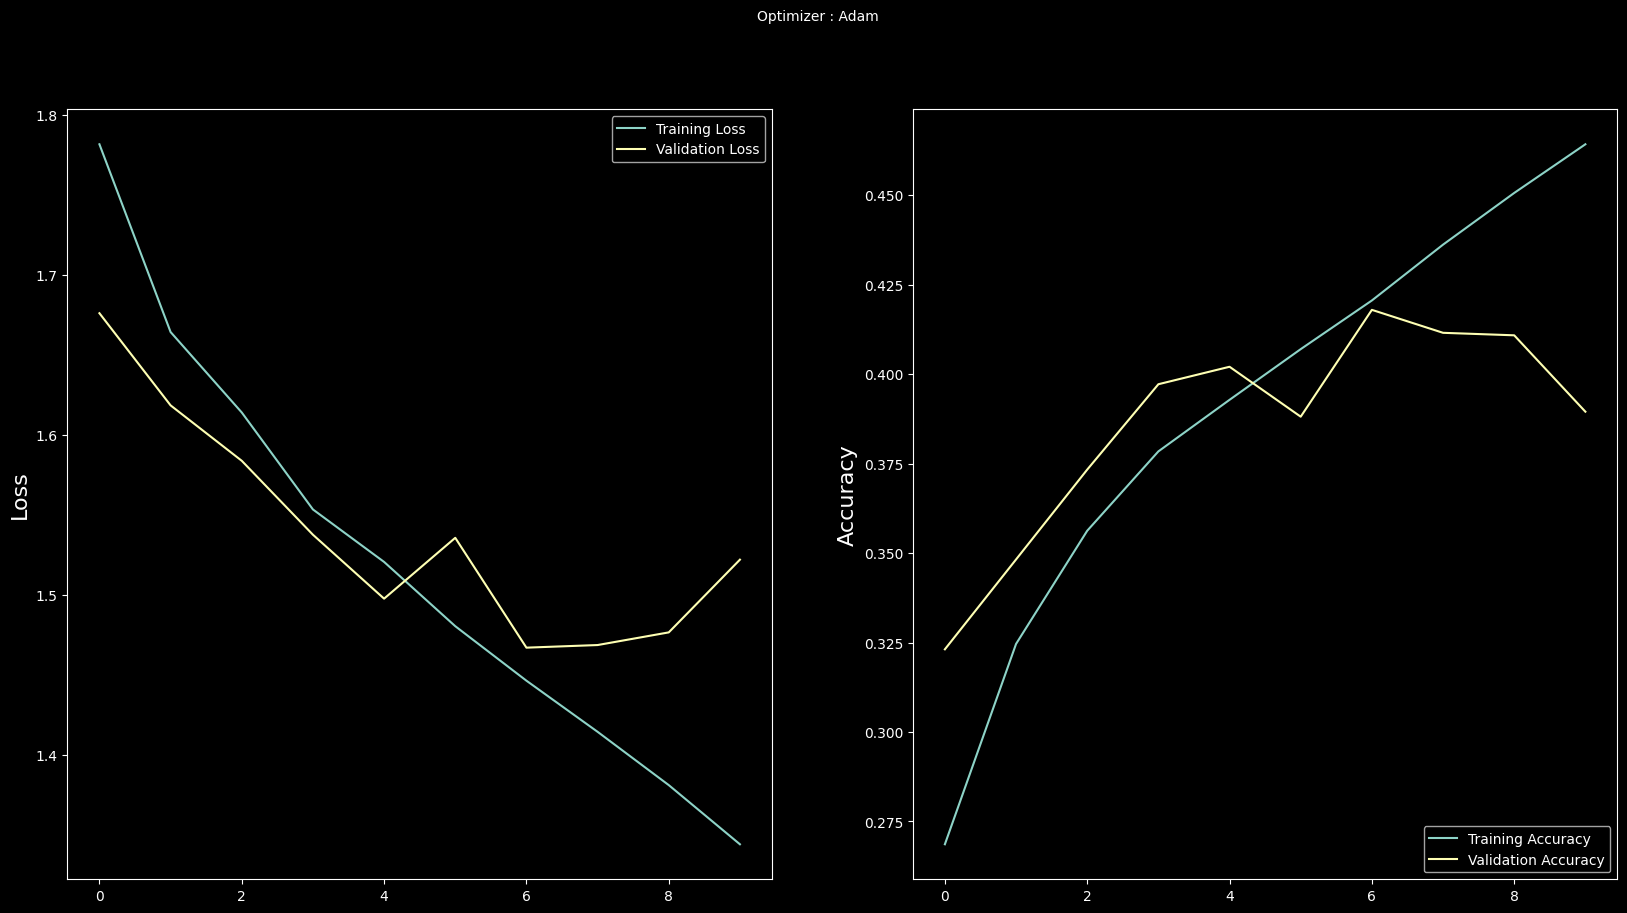

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

29/29 [==============================] - 9s 307ms/step


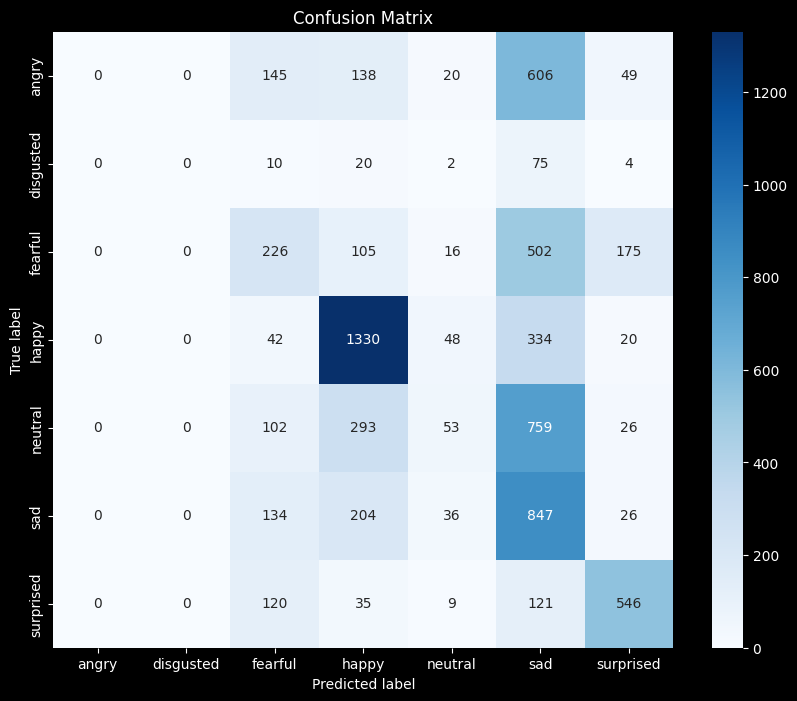

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model6.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.29      0.22      0.25      1024
       happy       0.63      0.75      0.68      1774
     neutral       0.29      0.04      0.07      1233
         sad       0.26      0.68      0.38      1247
   surprised       0.65      0.66      0.65       831

    accuracy                           0.42      7178
   macro avg       0.30      0.34      0.29      7178
weighted avg       0.37      0.42      0.36      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# model6.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/TretrainedVGGWithoutAugmetation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 7 (Pretrained Model Resnet-50)

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 128
epochs = 50

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=batch_size,
                                                    shuffle = True# Size of the batches of data
                                                )

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=batch_size,                # Size of the batches of data
                                                  shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
input_shape = (48, 48, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model7 = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])




In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint("./model7.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

optimizer = Adam(learning_rate=0.0001)
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_2 (Bat  (None, 2, 2, 2048)        8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)              

In [ ]:
history7 = model7.fit(
          train_generator,
          epochs=50,
          validation_data=test_generator,
          class_weight=class_weights_dict,
          callbacks = callbacks
          )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.8966 - accuracy: 0.1945

225/225 [==============================] - 55s 122ms/step - loss: 1.8966 - accuracy: 0.1945 - val_loss: 1.7504 - val_accuracy: 0.3146
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.5688 - accuracy: 0.3542

225/225 [==============================] - 27s 121ms/step - loss: 1.5688 - accuracy: 0.3542 - val_loss: 1.5094 - val_accuracy: 0.4273
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.4767

225/225 [==============================] - 27s 119ms/step - loss: 1.2676 - accuracy: 0.4767 - val_loss: 1.3348 - val_accuracy: 0.4909
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.0311 - accuracy: 0.5674

225/225 [==============================] - 27s 118ms/step - loss: 1.0311 - accuracy: 0.5674 - val_loss: 1.3084 - val_accuracy: 0.5160
Epoch 5/50
225/225 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.6369

225/225 [==============================] - 26s 117ms/step - loss: 0.8806 - accuracy: 0.6369 - val_loss: 1.2987 - val_accuracy: 0.5341
Epoch 6/50
225/225 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.7249

225/225 [==============================] - 27s 118ms/step - loss: 0.6708 - accuracy: 0.7249 - val_loss: 1.3785 - val_accuracy: 0.5323
Epoch 7/50
225/225 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7709

225/225 [==============================] - 29s 129ms/step - loss: 0.5751 - accuracy: 0.7709 - val_loss: 1.4207 - val_accuracy: 0.5518
Epoch 8/50
225/225 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.8313

Restoring model weights from the end of the best epoch: 5.
225/225 [==============================] - 27s 119ms/step - loss: 0.4427 - accuracy: 0.8313 - val_loss: 1.5875 - val_accuracy: 0.5479
Epoch 8: early stopping


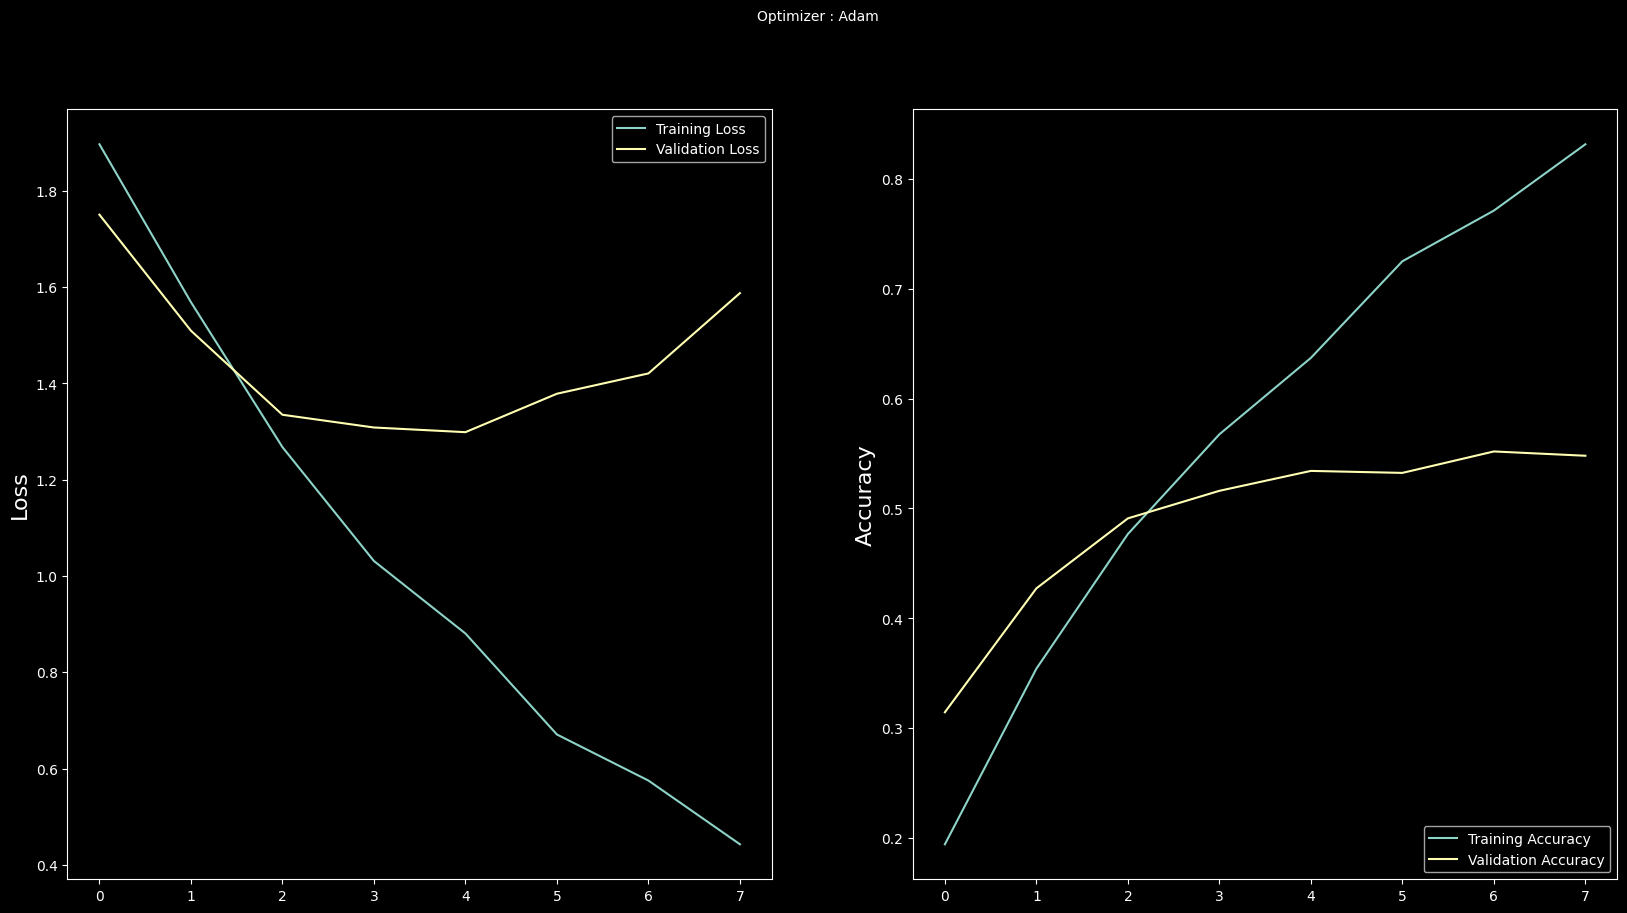

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
train_loss, train_accu = model7.evaluate(train_generator)
test_loss, test_accu = model7.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 4s 65ms/step - loss: 1.2987 - accuracy: 0.5341
final train accuracy = 75.40 , validation accuracy = 53.41


57/57 [==============================] - 5s 56ms/step


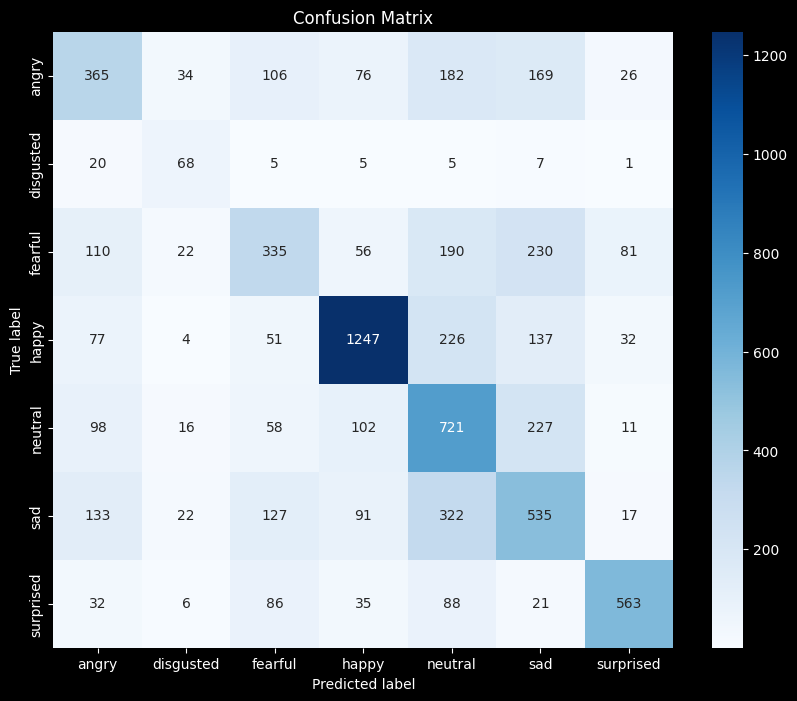

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model7.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.38      0.41       958
   disgusted       0.40      0.61      0.48       111
     fearful       0.44      0.33      0.37      1024
       happy       0.77      0.70      0.74      1774
     neutral       0.42      0.58      0.49      1233
         sad       0.40      0.43      0.42      1247
   surprised       0.77      0.68      0.72       831

    accuracy                           0.53      7178
   macro avg       0.52      0.53      0.52      7178
weighted avg       0.55      0.53      0.54      7178



In [ ]:
# model7.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/Resnet50V2Baisc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 8 Model Resnet-50 Augmetation)

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 128
epochs = 50

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',)

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(rescale = 1 / 255.,)

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=batch_size,                 # Size of the batches of data
                                                    shuffle = True)

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=batch_size,                 # Size of the batches of data
                                                  shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
input_shape = (48, 48, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model8 = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint("./model8.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

optimizer = Adam(learning_rate=0.001)
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_4 (Bat  (None, 2, 2, 2048)        8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)              

In [ ]:
history8 = model8.fit(
          train_generator,
          epochs=50,
          validation_data=test_generator,
          class_weight=class_weights_dict,
          callbacks = callbacks
          )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.9041 - accuracy: 0.1958

225/225 [==============================] - 83s 207ms/step - loss: 1.9041 - accuracy: 0.1958 - val_loss: 2.7302 - val_accuracy: 0.1753
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.7973 - accuracy: 0.1947

225/225 [==============================] - 46s 206ms/step - loss: 1.7973 - accuracy: 0.1947 - val_loss: 1.8758 - val_accuracy: 0.1588
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.7587 - accuracy: 0.2094

225/225 [==============================] - 45s 198ms/step - loss: 1.7587 - accuracy: 0.2094 - val_loss: 8.3617 - val_accuracy: 0.1718
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.6991 - accuracy: 0.2985

225/225 [==============================] - 46s 204ms/step - loss: 1.6991 - accuracy: 0.2985 - val_loss: 3.3482 - val_accuracy: 0.1131
Epoch 5/50
225/225 [==============================] - ETA: 0s - loss: 1.6823 - accuracy: 0.3206

Restoring model weights from the end of the best epoch: 2.
225/225 [==============================] - 45s 199ms/step - loss: 1.6823 - accuracy: 0.3206 - val_loss: 2.5305 - val_accuracy: 0.2615
Epoch 5: early stopping


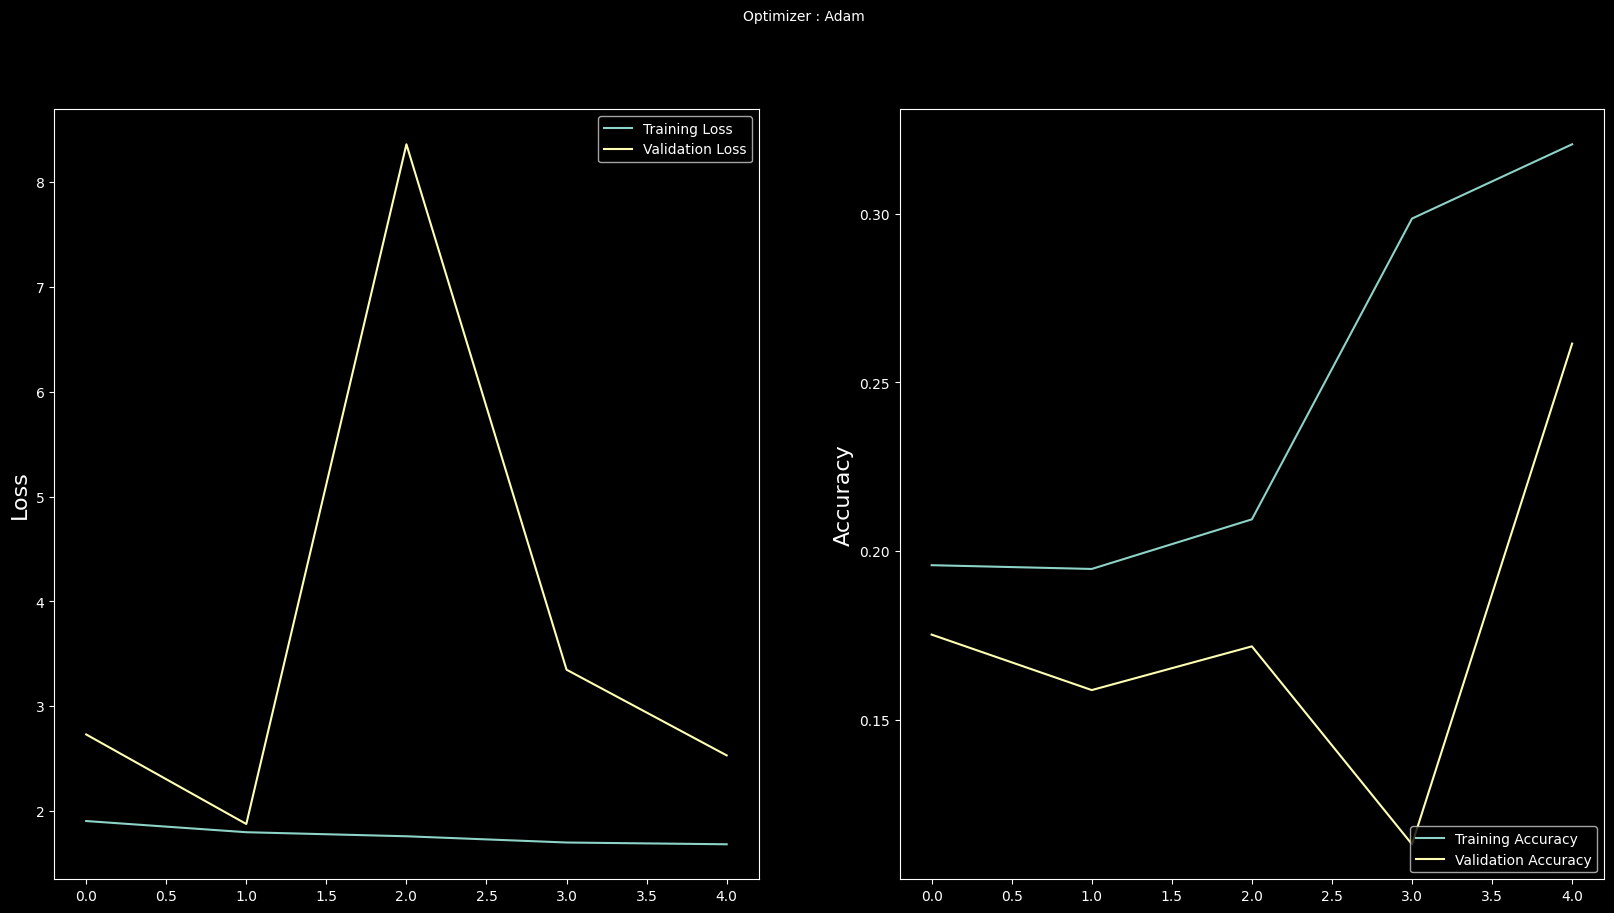

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history8.history['loss'], label='Training Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history8.history['accuracy'], label='Training Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

57/57 [==============================] - 3s 60ms/step - loss: 1.8758 - accuracy: 0.1588
final train accuracy = 13.45 , validation accuracy = 15.88
57/57 [==============================] - 3s 47ms/step


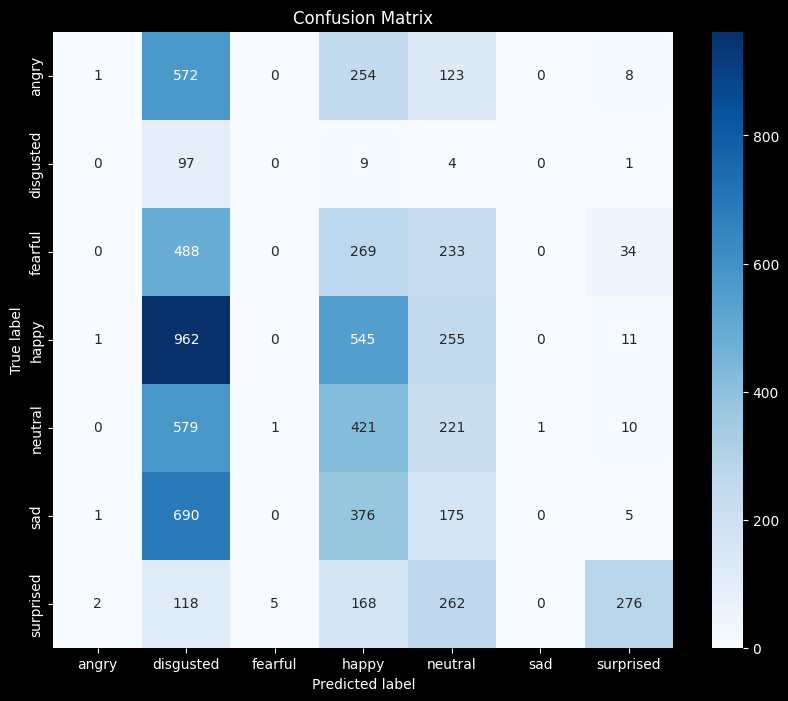

Classification Report:
               precision    recall  f1-score   support

       angry       0.20      0.00      0.00       958
   disgusted       0.03      0.87      0.05       111
     fearful       0.00      0.00      0.00      1024
       happy       0.27      0.31      0.29      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.00      0.00      0.00      1247
   surprised       0.80      0.33      0.47       831

    accuracy                           0.16      7178
   macro avg       0.21      0.24      0.14      7178
weighted avg       0.22      0.16      0.16      7178



In [ ]:
train_loss, train_accu = model8.evaluate(train_generator)
test_loss, test_accu = model8.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 4s 61ms/step


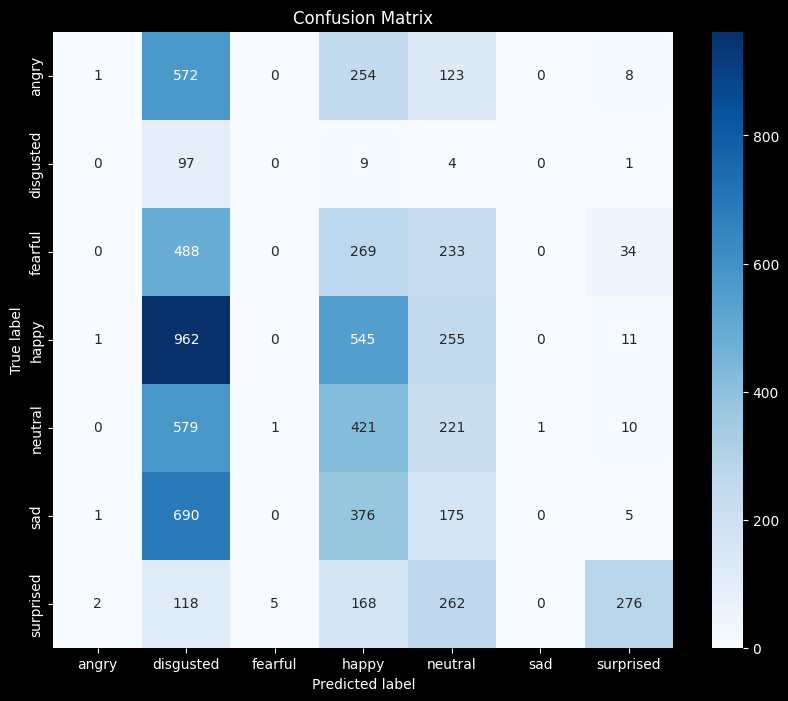

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model8.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.20      0.00      0.00       958
   disgusted       0.03      0.87      0.05       111
     fearful       0.00      0.00      0.00      1024
       happy       0.27      0.31      0.29      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.00      0.00      0.00      1247
   surprised       0.80      0.33      0.47       831

    accuracy                           0.16      7178
   macro avg       0.21      0.24      0.14      7178
weighted avg       0.22      0.16      0.16      7178



In [ ]:
# model8.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/Resnet50V2Augmentation.h5')

## Model 9 Resnet-50 Prettaiend with Augmentation)

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 128
epochs = 50

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',)

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(
                                  dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                  rescale = 1 / 255.,)

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=batch_size,                 # Size of the batches of data
                                                    shuffle = True)

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(img_width, img_height),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=batch_size,                 # Size of the batches of data
                                                  shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model9 = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])




In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint("./model9.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

optimizer = Adam(learning_rate=0.001)
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model9.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization_6 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)              

In [ ]:
history9 = model9.fit(
          train_generator,
          epochs=50,
          validation_data=test_generator,
          class_weight=class_weights_dict,
          callbacks = callbacks
          )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.6695 - accuracy: 0.3562

225/225 [==============================] - 520s 2s/step - loss: 1.6695 - accuracy: 0.3562 - val_loss: 2.3743 - val_accuracy: 0.2949
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.4756 - accuracy: 0.4410

225/225 [==============================] - 471s 2s/step - loss: 1.4756 - accuracy: 0.4410 - val_loss: 2.3880 - val_accuracy: 0.2421
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.3727 - accuracy: 0.4776

225/225 [==============================] - 472s 2s/step - loss: 1.3727 - accuracy: 0.4776 - val_loss: 2.3345 - val_accuracy: 0.3030
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.2982 - accuracy: 0.5058

225/225 [==============================] - 472s 2s/step - loss: 1.2982 - accuracy: 0.5058 - val_loss: 1.4810 - val_accuracy: 0.4550
Epoch 5/50
225/225 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.5235

225/225 [==============================] - 471s 2s/step - loss: 1.2469 - accuracy: 0.5235 - val_loss: 1.1645 - val_accuracy: 0.5543
Epoch 6/50
225/225 [==============================] - ETA: 0s - loss: 1.1867 - accuracy: 0.5479

225/225 [==============================] - 488s 2s/step - loss: 1.1867 - accuracy: 0.5479 - val_loss: 1.1952 - val_accuracy: 0.5534
Epoch 7/50
225/225 [==============================] - ETA: 0s - loss: 1.1625 - accuracy: 0.5566

225/225 [==============================] - 471s 2s/step - loss: 1.1625 - accuracy: 0.5566 - val_loss: 1.2063 - val_accuracy: 0.5571
Epoch 8/50
225/225 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.5610

Restoring model weights from the end of the best epoch: 5.
225/225 [==============================] - 479s 2s/step - loss: 1.1427 - accuracy: 0.5610 - val_loss: 1.1710 - val_accuracy: 0.5585
Epoch 8: early stopping


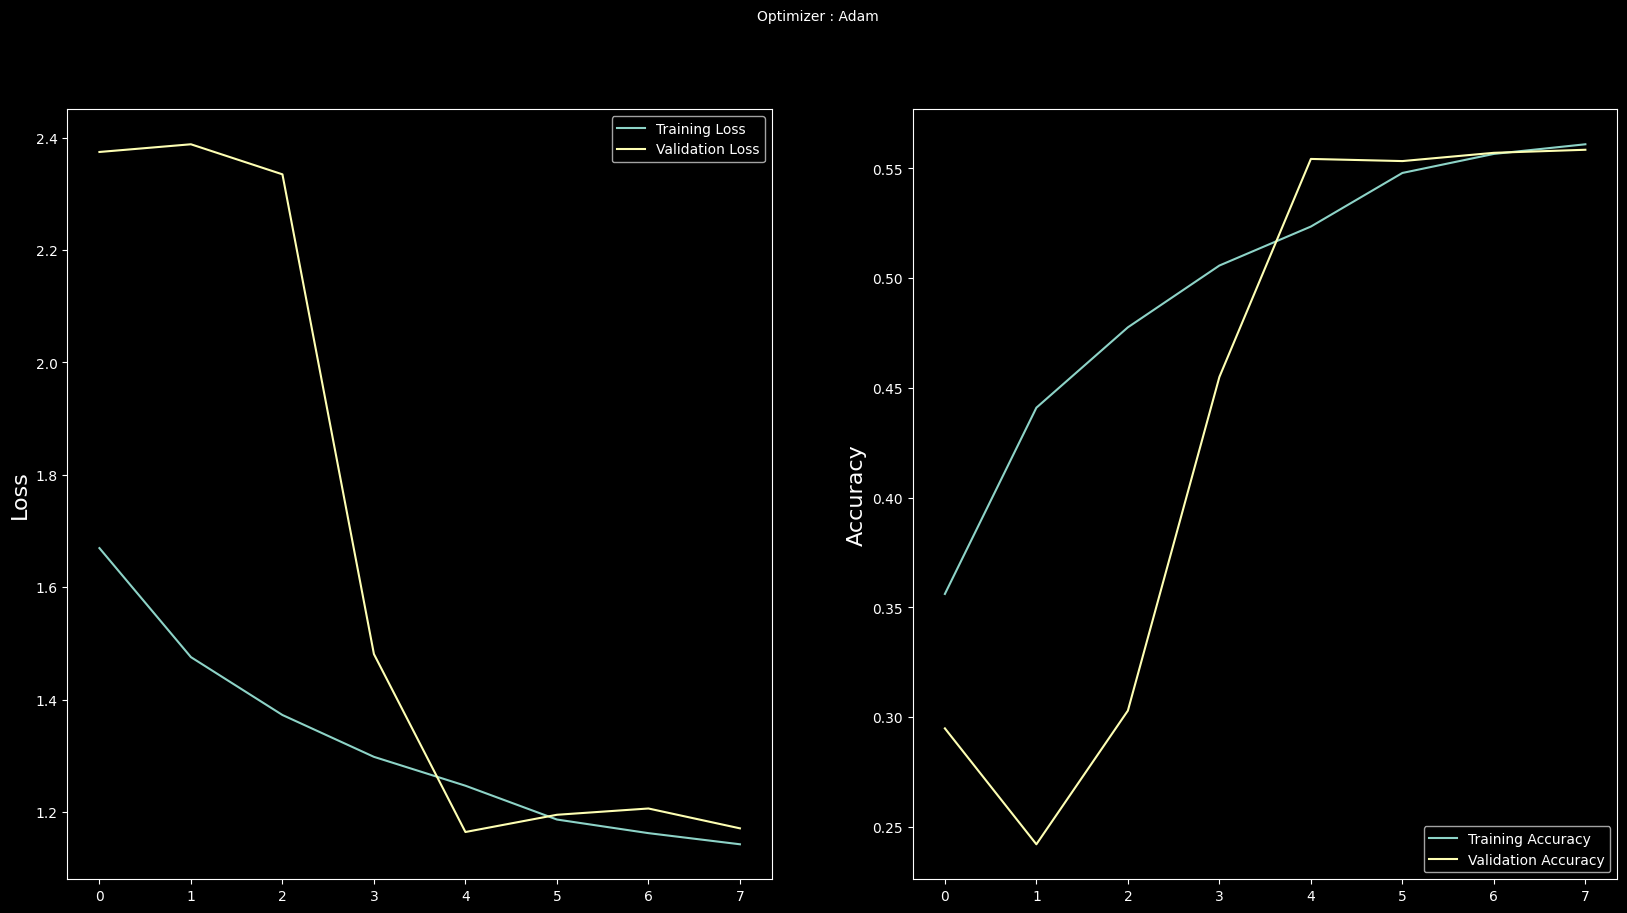

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history9.history['loss'], label='Training Loss')
plt.plot(history9.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history9.history['accuracy'], label='Training Accuracy')
plt.plot(history9.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
train_loss, train_accu = model9.evaluate(train_generator)
test_loss, test_accu = model9.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))



57/57 [==============================] - 22s 377ms/step - loss: 1.1645 - accuracy: 0.5543
final train accuracy = 54.56 , validation accuracy = 55.43


57/57 [==============================] - 24s 407ms/step


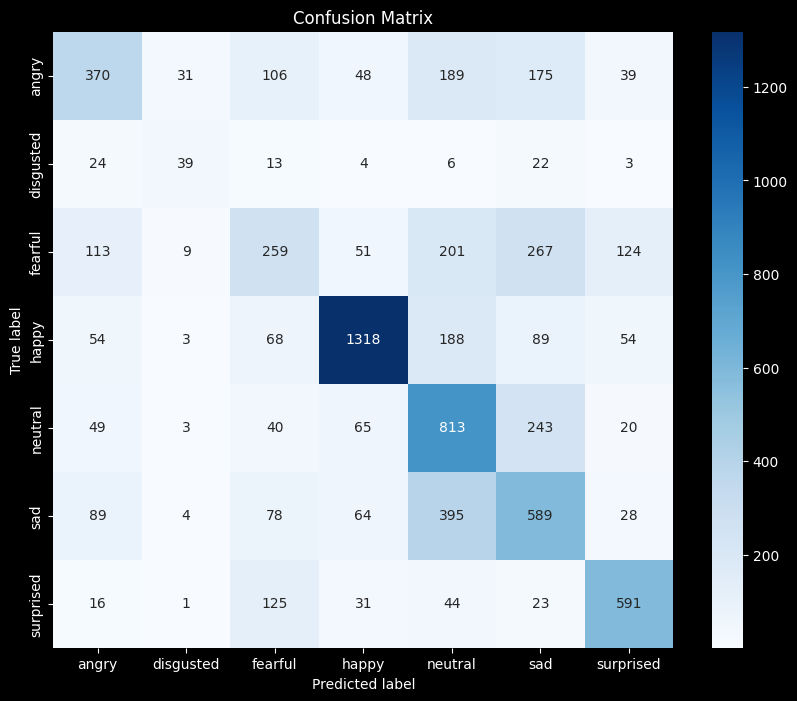

In [ ]:

# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model9.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.52      0.39      0.44       958
   disgusted       0.43      0.35      0.39       111
     fearful       0.38      0.25      0.30      1024
       happy       0.83      0.74      0.79      1774
     neutral       0.44      0.66      0.53      1233
         sad       0.42      0.47      0.44      1247
   surprised       0.69      0.71      0.70       831

    accuracy                           0.55      7178
   macro avg       0.53      0.51      0.51      7178
weighted avg       0.56      0.55      0.55      7178



In [ ]:
model9.save(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/Resnet50V2PretrainedAug224.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing Images

### Model 1

In [ ]:
## Load model
model = load_model(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchModel.h5')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = r"/content/test/surprised/im110.png"
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
# Convert the image to a numpy array
img_array = image.img_to_array(img)
# Reshape the image array to match the input shape required by the model
img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # or other normalization method used during training


In [ ]:
# Make a prediction
prediction = model.predict(img_array)
# Since the model outputs a probability distribution, get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
# print(index_to_emotion)
predicted_label = index_to_emotion[predicted_class[0]]
print(f'Predicted class: {predicted_label}')


1/1 [==============================] - 0s 92ms/step
Predicted class: surprise


### Model 2

In [ ]:
## Load model
model2 = load_model(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchTriallModel.h5')

import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = r"/content/test/happy/im110.png"
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
# Convert the image to a numpy array
img_array = image.img_to_array(img)
# Reshape the image array to match the input shape required by the model
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # or other normalization method used during training


In [ ]:
# Make a prediction
prediction = model2.predict(img_array)
# Since the model outputs a probability distribution, get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
# print(index_to_emotion)
predicted_label = index_to_emotion[predicted_class[0]]
print(f'Predicted class: {predicted_label}')


1/1 [==============================] - 2s 2s/step
Predicted class: happy


### Model 3

In [ ]:
## Load model
model3 = load_model(r'/content/drive/MyDrive/Hands-On-Deep-Learning/Emotion-Detection/CNNFromScratchAugmentedModel.h5')

import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = r"/content/test/angry/im100.png"
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
# Convert the image to a numpy array
img_array = image.img_to_array(img)
# Reshape the image array to match the input shape required by the model
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # or other normalization method used during training


In [ ]:
# Make a prediction
prediction = model3.predict(img_array)
# Since the model outputs a probability distribution, get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
# print(index_to_emotion)
predicted_label = index_to_emotion[predicted_class[0]]
print(f'Predicted class: {predicted_label}')


1/1 [==============================] - 0s 321ms/step
Predicted class: angry
